Link to Github repository: https://github.com/fridamariejoergensen/CSS.git <br>
### Contribution Statement

We, Frida(s206182), Cecilie(sXXXXXX), and Marie(s204052), collaborated on Assignment 1 in Jupyter Notebook and made the following contributions:

- Cecilie focused on this

- Frida did this

- Marie did this



# Assignment 1

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import pickle
import logging
import os
import math

## Part 1: Using web-scraping to gather data

### 2019 edition

In [3]:
## Poster
LINK = "https://2019.ic2s2.org/posters/"
r = requests.get(LINK) 
soup = BeautifulSoup(r.content)

In [5]:
listul = soup.find("div",{"class":"col-md-8 page-content-wrap"})
listli = listul.find_all("li")

allnames = []
for i in range(len(listli)):
    if listli[i].find("strong"):
        listli[i].strong.extract()
    if listli[i].find("span"):
        listli[i].span.extract()
    if listli[i].find("br"):
        listli[i].br.extract()
        
    names = listli[i].text.replace("\n","").replace(" and ",",").replace(", ",",")
    allnames = allnames + names.split(",")
    


un2019 = np.unique(np.array(allnames))
len(un2019)

461

There was 461 unique researchers that made poster presentations in 2019  

In [6]:
#### Oral
LINK = 'https://2019.ic2s2.org/oral-presentations/'
r = requests.get(LINK)
all_oral = BeautifulSoup(r.content)

In [7]:
# extract the specific element of the site that contains the names
paragraphs = all_oral.find_all("p", {"class":""})[3:39]

In [8]:
names = []
for p in paragraphs:
    text = p.text.strip()
    lines = text.split(' – ')
    names.extend([line.split('.')[0] for line in lines[1:]])

In [9]:
# code that extracts list elements that contain numbers.

def remove_elements_with_numbers(names):
    return [i for i in names if not any(j.isdigit() for j in i)]

p = remove_elements_with_numbers(names)

In [10]:
newlist = [word for line in p for word in line.split(',')]
newlist.remove('No Presentation')
final_list = np.asarray(newlist)
print(len(np.unique(final_list)))

521


There was 521 unique researchers that made oral presentations in 2019  

In [12]:
# Combine the two lists of poster and oral presentators
combined_list = np.unique(np.concatenate((final_list, un2019)))
# Find the length of unique combined list that attended the conference in 2019 
print(len(combined_list))

953


In total we found 953 unique researchers in 2019.

Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?

## Part 2: Getting data from the Semantic Scholar API
Consider the list of author ids you have found in Week 2, Part 3, first excercise. For each author, use the Academic Graph API to find: <br>
- their aliases <br>
- their name <br>
- their papers <br>

(**Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not!!)

Create three dataframe to store the data you have collected:

**Author dataset**: in the author dataset, one raw is one unique author, and each row contains the following information: <br>
- authorId: (str) the id of the author <br>
- name: (str) the name of the author <br> 
- aliases: (list) the aliases of the author <br>
- citationCount: (int) the total number of citations received by an author <br>
- field: (str) the s2FieldsOfStudy that occurs most times across an author's papers (you should first obtain the category for each s2FieldsOfStudy) 



**Paper dataset**: in the paper dataset, one row is one unique paper, and each row contains the following information: <br>
- paperId: (str) the id of the paper <br>
- title: (str) the title of the paper <br> 
- year: (int) the year of publication <br>
- externalId.DOI: (str) the DOI of the paper <br>
- citationCount: (int) the number of citations <br>
- fields: (list) the fields included in the paper (you should first obtain the category for each s2FieldsOfStudy) <br>
-  authorIds: (list) this is a list of author Ids, including all the authors of this paper that are in our author dataset



**Paper abstract dataset**: in the paper abstract dataset, one row is one unique paper, and each row contains the following information: <br>
- paperId: (str) the id of the paper <br>
- abstract: (str) the abstract of the paper


In [13]:
#Open txt file for logging the events that happen when collecting all the data:
open('collectingData.log','a+')

logging.basicConfig(filename='collectingData.log', 
filemode='a',
level=logging.INFO, 
format='%(asctime)s | %(name)s | %(levelname)s | %(message)s')

In [16]:
# Code to load pickle with all names of comp sci people:
with open("pickles/all_names","rb") as fp:
    all_names = pickle.load(fp)
print(len(all_names))

122293


In [17]:
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"

author_url = BASE_URL + VERSION + "author/batch"

class compSciData:
    def __init__(self,authorIds,picklePath="pickles"):
        self.authorIds = authorIds
        logging.info("Length of author Id list: {}".format(len(authorIds)))
        self.authordf = pd.DataFrame(columns = ['authorId','name', 'aliases','citationCount','field'])
        self.paperdf = pd.DataFrame(columns = ['paperId','title', 'year','externalId.DOI','citationCount','fields','authorIds'])
        self.abstractdf = pd.DataFrame(columns = ['paperId','abstract'])    
        self.authordict= {}
        self.paperdict = {}
        self.abstractdict = {}
        self.checkedAuthors = {}
        self.faultyAuthors = {}
        self.picklePath = picklePath
        self.authorURL = BASE_URL + VERSION + "author/batch"
        

    def loadPickles(self):
        if os.path.isfile(self.picklePath+"/finalAuthorDf"):
            self.authordf = pickle.load( open(self.picklePath+"/finalAuthorDf", "rb" ) )
            #print("Opened pickle with author dataframe.")
            logging.info("Opened pickle with author dataframe.")

        if os.path.isfile(self.picklePath+"/finalPaperDf"):
            self.paperdf = pickle.load( open( self.picklePath+"/finalPaperDf", "rb" ) )
            #print("Opened pickle with paper dataframe.")
            logging.info("Opened pickle with paper dataframe.")

        if os.path.isfile(self.picklePath+"/finalAbstractDf"):
            self.abstractdf = pickle.load( open( self.picklePath+"/finalPaperDf", "rb" ) )
            #print("Opened pickle with abstract dataframe.")
            logging.info("Opened pickle with abstract dataframe.")

        if os.path.isfile(self.picklePath+"/checkedAuthors"):
            self.checkedAuthors = pickle.load( open( self.picklePath+"/checkedAuthors", "rb" ) )
            #print("Opened pickle with checked authors of length {}.".format(len(self.checkedAuthors)))
            logging.info("Opened pickle with checked authors of length {}.".format(len(self.checkedAuthors)))


    def handleRequests(self,cleanAuthBatch):
        #Send request for the given ids:
        params = {"ids":cleanAuthBatch,
                                "limit":10000}
        r = requests.post(self.authorURL+"?fields=aliases,name,papers,papers.title,papers.abstract,papers.citationCount,"
        +"papers.s2FieldsOfStudy,papers.year,papers.externalIds,papers.authors", json=params)
        data = r.json()
        
        # If data returns message, there is some error, which is likely either too many requests or an internal server error
        if type(data)==list:
            self.sortAuthorDataInDataframesDict(data,cleanAuthBatch)
            # Sleep three secs per request to not exceed 100 requests per 5 min.
            time.sleep(3)
        elif 'message' in data.keys():
            #print("Request returned a message: "+data['message'])
            logging.warning("Request returned a message: "+data['message'])
            if data['message']=='Internal server error' or data['message']=='Endpoint request timed out':
                # Sleep three secs per request to not exceed 100 requests per 5 min.
                time.sleep(3)
                self.findFaultyData(cleanAuthBatch)
            elif data['message']=='Too Many Requests':
                time.sleep(30)
                self.handleRequests(cleanAuthBatch)
            else: 
                #If some other error just pass to next clean batch after waiting a bit:
                time.sleep(30)
                pass

    def findFaultyData(self, cleanAuthBatch):
        batchLength = len(cleanAuthBatch)
        #print("Initiating search for faulty data with batchLength {}.".format(batchLength))
        logging.info("Initiating search for faulty data with batchLength {}.".format(batchLength))
        if batchLength>3:
            middleindex = batchLength//2
            halves = [cleanAuthBatch[:middleindex],cleanAuthBatch[middleindex:]]
            for half in halves:
                self.handleRequests(half)
        elif batchLength>1:
            halves = [[id] for id in cleanAuthBatch]
            for half in halves:
                self.handleRequests(half)
        else:
            #print("Faulty id: Found that author with id {} returns a server error upon request.".format(cleanAuthBatch))
            logging.warning("Faulty id: Found that author with id {} returns a server error upon request.".format(cleanAuthBatch))
            #Save in the checked authors list, so we don't check author again.
            self.checkedAuthors[cleanAuthBatch[0]]=1 
            self.faultyAuthors[cleanAuthBatch[0]]="error"          

    
    def sortAuthorDataInDataframesDict(self,data,cleanAuthBatch):
        # Takes data object containing the info returned from a request with authorIds. Sorts the data
        # into the dataframes contained in self.
        #print("Initiating sortAuthorDataInDataframesDict")
        logging.info("Initiating sortAuthorDataInDataframesDict")

        # Look at every author:
        for i in range(len(data)):
            # Only proceed if the request for current author did return something, aka didn't return None
            if data[i]:
                authorData = data[i]
                papers = authorData['papers']
                #initialize variables for later:
                fields = []
                citationCount = 0
                
                #Look at everyone of their papers:
                for n in range(len(papers)):
                    paper = papers[n]
                    paper_fields = []
                    for s2 in paper['s2FieldsOfStudy']:
                        paper_fields.append(s2['category'])
                    fields=fields+paper_fields
                    citationCount += paper['citationCount']

                    paper_authors = []
                    for auth in paper['authors']:
                        paper_authors.append(auth['authorId'])


                    self.paperdict[paper['paperId']] = {'paperId':paper['paperId'],'title':paper['title'], 'year':paper['year'],
                    'externalId.DOI': paper['externalIds'].get('DOI'),'citationCount':paper['citationCount'],'fields':[paper_fields],
                    'authorIds':[paper_authors]}

                    self.abstractdict[paper['paperId']] = {'paperId':paper['paperId'],'abstract':paper['abstract']}

                self.authordict[authorData['authorId']] = {'authorId' : authorData['authorId'], 'name' : authorData['name'], 
                'aliases' : [authorData['aliases']],'citationCount':citationCount,'field': max(fields,key=fields.count) if fields else None}

                # Add authorId to dict with checked authors:
                self.checkedAuthors[authorData['authorId']]=1

            else:
                #print("Author with id {} returned a Nonetype object.".format(cleanAuthBatch[i]))
                logging.info("Author with id {} returned a Nonetype object.".format(cleanAuthBatch[i]))
                self.checkedAuthors[cleanAuthBatch[i]]=1
                self.faultyAuthors[cleanAuthBatch[i]]="none"


    def findData(self, batchsize=100):
        # Avoid batchsize errors:
        if batchsize>100:
            #print("Batchsize can maximum be 100 because we are requesting fields=papers attributes.")
            logging.error("Batchsize can maximum be 100 because we are requesting fields=papers attributes.")
            return
        
        # Find papers for every name:
        batches = math.floor(len(self.authorIds)/batchsize)
        for k in range(batches+1):
            #Calculate indexes for next batch:
            lowerbound = k*batchsize
            if k == batches:
                upperbound = lowerbound+len(self.authorIds)%batchsize
            else:
                upperbound = lowerbound+batchsize
            
            #Remove all authors that have already been checked:
            authBatch = self.authorIds[lowerbound:upperbound]
            cleanAuthBatch = []
            for id in authBatch:
                if id not in self.checkedAuthors:
                    cleanAuthBatch.append(id)

            #Only proceed if there are still authors left after cleaning
            if len(cleanAuthBatch)>0:
                
                # Takes authorIds that have not yet been used and handles the request, errorhandling and puts data in 
                # to dataframes in helper functions:
                self.handleRequests(cleanAuthBatch)

                print("Code has processed {} names.".format(upperbound))
                logging.info("Code has processed {} names.".format(upperbound))

                #Save pickles during process as a back up.
                if upperbound%5000==0:
                    self.savePickles(path="pickles/{}".format(upperbound))

    
    def savePickles(self, path="pickles"):
        #Concatenate dataframe so far with the recently collected dicts:
        self.authordf = pd.concat([self.authordf,pd.DataFrame.from_dict(self.authordict,"index")], ignore_index=True)
        self.paperdf = pd.concat([self.paperdf,pd.DataFrame.from_dict(self.paperdict,"index")], ignore_index=True)
        self.abstractdf = pd.concat([self.abstractdf,pd.DataFrame.from_dict(self.abstractdict,"index")], ignore_index=True)

        #Clear dicts, so we don't save them into the dataframe twice:
        self.authordict={}
        self.paperdict={}
        self.abstractdict={}

        #Create folder if it does not exist:
        if not os.path.exists(path):
            os.makedirs(path)

        # Save the pickles:
        pickle.dump(self.authordf,open("{}/finalAuthorDf".format(path),"wb"))
        pickle.dump(self.paperdf,open("{}/finalPaperDf".format(path),"wb"))
        pickle.dump(self.abstractdf,open("{}/finalAbstractDf".format(path),"wb"))
        pickle.dump(self.checkedAuthors,open("{}/checkedAuthors".format(path),"wb"))
        print("Pickles saved succesfully to path {}!".format(path))
        logging.info("Pickles saved succesfully to path {}!".format(path))

In [21]:
# Call the class above and start creating dataframes with the comp sci names.
# Currently just inputting 100 names. In our actual runs, we slowly included all the names.
data = compSciData(authorIds=list(all_names.keys())[:400],picklePath ="pickles")
data.loadPickles()
data.findData(batchsize=100)
data.savePickles()

logging.info("There were {} faulty authorIds, which were:".format(len(data.faultyAuthors)))
logging.info(data.faultyAuthors)

logging.info("The author dataframe has length:".format(len(data.authordf)))
logging.info("The paper dataframe has length:".format(len(data.paperdf)))

Code has processed 400 names.
Pickles saved succesfully to path pickles!


How long is your final Author dataframe? How long is your final Paper dataframe?

## Part 3: Law of large numbers.

In [2]:
# 1. Sampling points from Gaussian distribution with mean = 0 and std = 4
N = 10000
mu = 0
sigma = 4

X = np.random.normal(mu, sigma, N)

-15.896114433468773 14.415505136814982


Text(0.5, 1.0, 'Distribution of data')

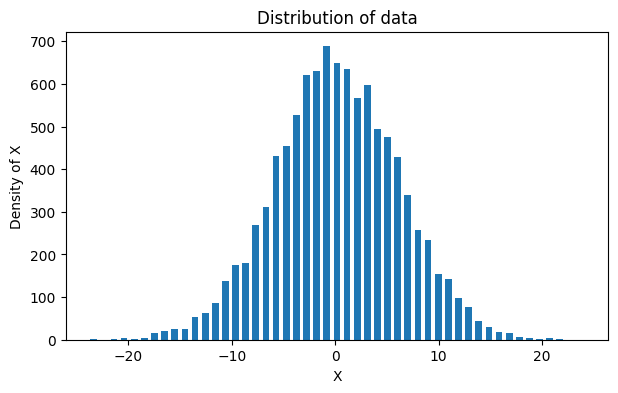

In [3]:
# 2. Plotting the distribution of data in a histogram
print(min(X), max(X))
bins = np.linspace(-16, 16, 50)
hist, edges = np.histogram(X, bins=bins)
x = edges[1:]+edges[:-1]/2
width = bins[1]-bins[0]
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x, hist, width)
ax.set_ylabel('Density of X')
ax.set_xlabel('X')
ax.set_title('Distribution of data')

In [4]:
# 3. Cumulative average of X
cum_av = np.array([])
for i in range(1, N+1):
    val = X[0:i]
    cum_av = np.append(cum_av, np.mean(val))
    
print(cum_av)

[4.89985315 5.31033911 2.16471458 ... 0.00535029 0.00591037 0.00567441]


In [5]:
# 4. Cumulative std of X
cum_std = np.array([])
for i in range(1, N+1):
    val = X[0:i]
    cum_std = np.append(cum_std, np.std(val)/np.sqrt(N))
    
print(cum_std)

[0.         0.00410486 0.04461193 ... 0.03978299 0.03978495 0.03978366]


In [6]:
# 5. Computing distribution mean and median from Wikipedia formulas
mean = 1/N * sum(X)

X_new = np.copy(X)
X_new = np.sort(X_new)
median = (X_new[int(N/2)] + X_new[int((N/2+1))])/2

print(mean, median)

0.0056744124799504095 -0.05648402466167323


Text(0.5, 1.0, 'Line plot of cumulative average with error bars')

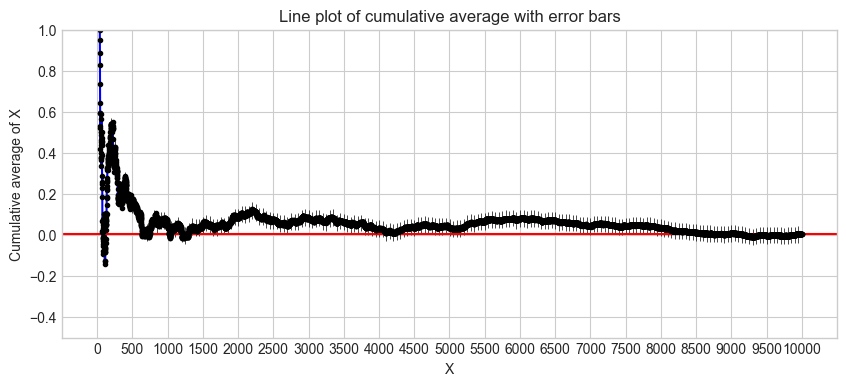

In [13]:
# 6. Line plot of cumulative average with error bars and horizontal line of distribution mean
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,4))
plt.plot(range(N), cum_av, c = 'blue')
plt.errorbar(range(N), cum_av, yerr = cum_std, fmt='.k', errorevery=(1, 50), elinewidth=0.5)
plt.axhline(mean, c = 'red')
plt.xticks(np.arange(0,10100,step=500))
plt.ylim(-0.5,1)
plt.ylabel('Cumulative average of X')
plt.xlabel('X')
plt.title('Line plot of cumulative average with error bars')

In [14]:
# 7. Cumulative median of X
cum_median = np.array([])
for i in range(1, N+1):
    val = X[0:i]
    cum_median = np.append(cum_median, np.median(val))
    
print(cum_median)

[ 4.89985315  5.31033911  4.89985315 ... -0.05694319 -0.05680126
 -0.05694319]


(-1.0, 1.0)

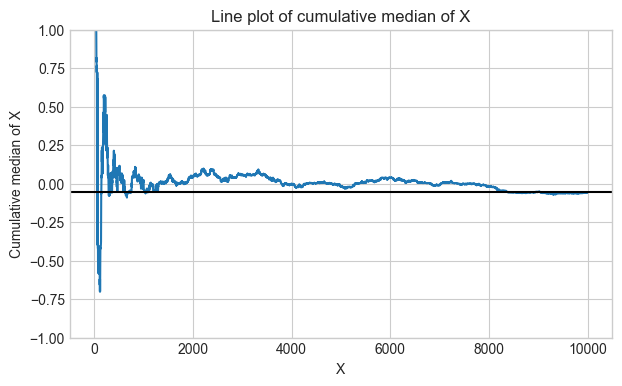

In [16]:
# 8. Line plot of cumulative median and horizontal line of distribution median
plt.figure(figsize=(7,4))
plt.plot(range(N), cum_median)
plt.axhline(median, c = 'black')
plt.title('Line plot of cumulative median of X')
plt.xlabel('X')
plt.ylabel('Cumulative median of X')
plt.ylim(-1,1)

In [17]:
# 9. Sampling from Pareto distribution with x_m = 1 and alpha = 0.5
N = 10000
x_m = 1
alpha = 0.5

Data = np.random.pareto(alpha, N)

0.0002960749249862893 298842957.1929424


Text(0.5, 0, 'Logarithmic X')

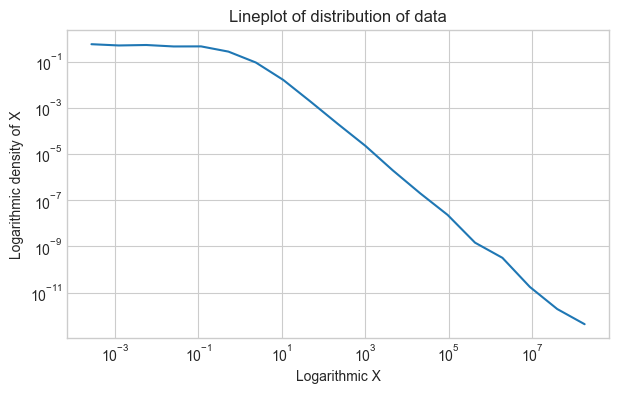

In [19]:
# 10.2 Plotting distribution of Pareto data
print(min(Data), max(Data))
bins = np.logspace(np.log10(0.0001), np.log10(298842958), 20)
hist, edges = np.histogram(Data, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
# removing empty bins
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(xx, yy, width)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Lineplot of distribution of data')
ax.set_ylabel('Logarithmic density of X')
ax.set_xlabel('Logarithmic X')

In [50]:
# 10.3 Computing cumulative average of X
cum_av = np.array([])
for i in range(1, N+1):
    val = Data[0:i]
    cum_av = np.append(cum_av, np.mean(val))
    
print(cum_av)

# 10.4 Computing cumulative std of X
cum_std = np.array([])
for i in range(1, N+1):
    val = Data[0:i]
    cum_std = np.append(cum_std, np.std(val)/np.sqrt(N))
    
print(cum_std)

# 10.5 Computing distribution mean and median from Wikipedia formulas
mean = 1/N * sum(Data)
Data_new = np.copy(Data)
Data_new = np.sort(Data_new)
median = (Data_new[int(N/2)] + Data_new[int((N/2)+1)])/2
print(mean, median)

[  133.82922602    97.44503783    65.38130619 ... 36363.31581926
 36359.67919381 36356.04329727]
[0.00000000e+00 3.63841882e-01 5.42098257e-01 ... 3.00543525e+04
 3.00528499e+04 3.00513474e+04]
36356.043297266595 2.956808905524922


Text(0.5, 1.0, 'Line plot of cumulative average with error bars')

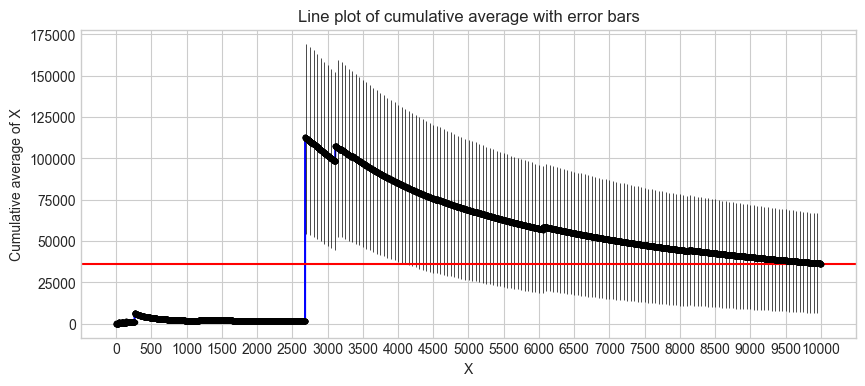

In [51]:
# 10.6 Line plot of cumulative average with error bars and horizontal line of distribution mean
plt.figure(figsize=(10,4))
plt.plot(range(N), cum_av, c = 'blue')
plt.errorbar(range(N), cum_av, yerr = cum_std, fmt='.k', errorevery=(1, 50), elinewidth=0.5)
plt.axhline(mean, c = 'red')

plt.xticks(np.arange(0,10100,step=500))
#plt.ylim(-1.5,1)
plt.ylabel('Cumulative average of X')
plt.xlabel('X')
plt.title('Line plot of cumulative average with error bars')

[133.82922602  97.44503783  61.06084964 ...   2.95680891   2.95645092
   2.95586736]


Text(0.5, 1.0, 'Line plot of cumulative median and calculated median')

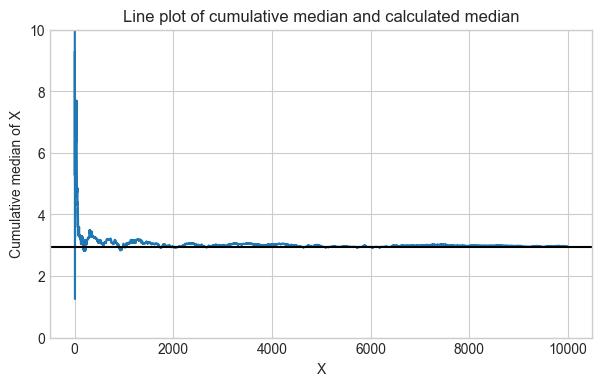

In [28]:
# 10.7 Cumulative median of X
cum_median = np.array([])
for i in range(1, N+1):
    val = Data[0:i]
    cum_median = np.append(cum_median, np.median(val))
    
print(cum_median)

# 9.8 Plot of cumulative median and horizontal line of distribution median
plt.figure(figsize=(7,4))
plt.plot(range(N), cum_median)
plt.axhline(median, c = 'black')
plt.ylim(0,10)
plt.xlabel('X')
plt.ylabel('Cumulative median of X')
plt.title('Line plot of cumulative median and calculated median')

In [29]:
# 11. Sampling from LogNormal distribution with mean = 0 and std = 4
N = 10000
mu = 0
sigma = 4

log_normal = np.random.lognormal(mu, sigma, N)

2.868054740189983e-07 626779.0617472928


Text(0.5, 1.0, 'Distribution of data X')

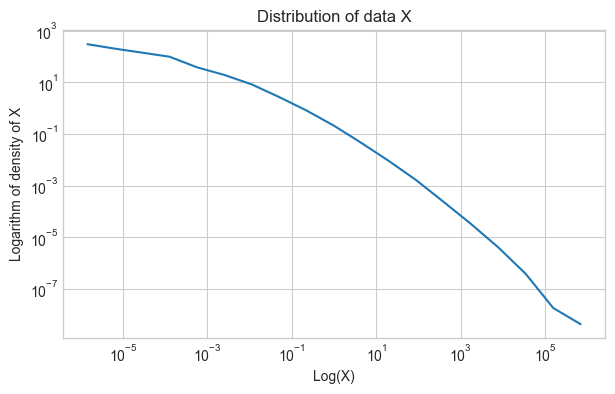

In [35]:
# 12.2 Line plot of distribution of data
print(min(log_normal), max(log_normal))

bins = np.logspace(np.log10(2.9e-7), np.log10(626780), 20)
hist, edges = np.histogram(log_normal, bins=bins, density=True)
x = edges[1:]+edges[:-1]/2
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(xx, yy)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Log(X)')
ax.set_ylabel('Logarithm of density of X')
ax.set_title('Distribution of data X')

In [36]:
# 12.3 Computing cumulative average of X
cum_av = np.array([])
for i in range(1, N+1):
    val = log_normal[0:i]
    cum_av = np.append(cum_av, np.mean(val))
    
print(cum_av)

# 12.4 Computing cumulative std of X
cum_std = np.array([])
for i in range(1, N+1):
    val = log_normal[0:i]
    cum_std = np.append(cum_std, np.std(val)/np.sqrt(N))
    
print(cum_std)

# 12.5 Computing distribution mean and median (from Wiki formulas)
mean = 1/N * sum(log_normal)
log_normal_new = np.copy(log_normal)
log_normal_new = np.sort(log_normal_new)
median = (log_normal_new[int(N/2)] + log_normal_new[int((N/2)+1)])/2
print(mean, median)

[1.64027596e-02 2.16510718e+01 1.44352626e+01 ... 9.73977038e+02
 1.00084484e+03 1.00074524e+03]
[  0.           0.21634669   0.20400369 ... 155.26725115 157.56662985
 157.5587828 ]
1000.745236362239 0.9720402965603887


Text(0.5, 1.0, 'Line plot of cumulative average of X with error bars')

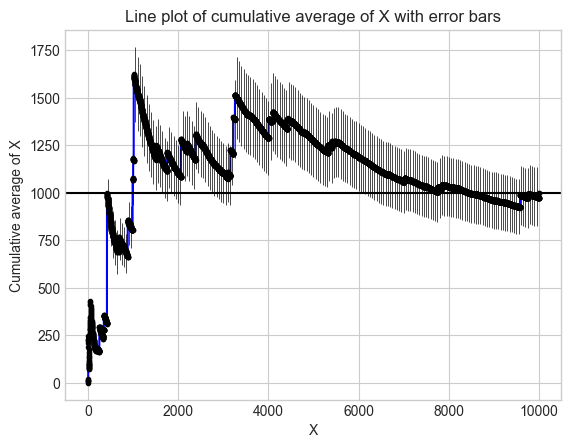

In [39]:
# 12.6 Plot of cumulative average as line plot with error bars and horizontal line of distribution mean
plt.plot(range(N), cum_av, c = 'blue')
plt.errorbar(range(N), cum_av, yerr = cum_std, fmt='.k', errorevery=(1, 50), elinewidth=0.5)
plt.axhline(mean, c = 'black')
plt.xlabel('X')
plt.ylabel('Cumulative average of X')
plt.title('Line plot of cumulative average of X with error bars')

[1.64027596e-02 2.16510718e+01 1.64027596e-02 ... 9.69104475e-01
 9.69132753e-01 9.69287812e-01]


Text(0.5, 1.0, 'Line plot of cumulative median with black line of distribution median')

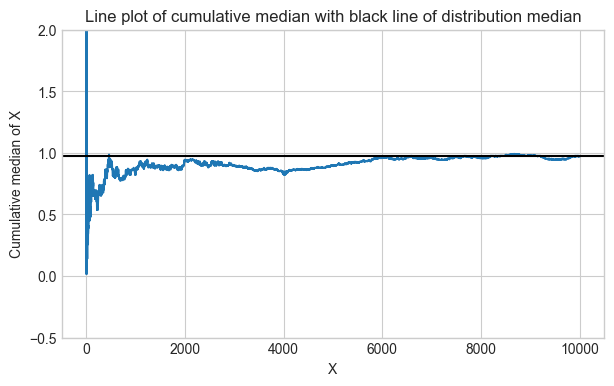

In [47]:
# 12.7 Cumulative median of X
cum_median = np.array([])
for i in range(1, N+1):
    val = log_normal[0:i]
    cum_median = np.append(cum_median, np.median(val))
    
print(cum_median)

# 12.8 Plot of cumulative median and horizontal line of distribution median
plt.figure(figsize=(7,4))
plt.plot(range(N), cum_median)
plt.axhline(median, c = 'black')
plt.ylim(-0.5,2)
plt.ylabel('Cumulative median of X')
plt.xlabel('X')
plt.title('Line plot of cumulative median with black line of distribution median')

In [23]:
# 13 Code to load pickle with paper dataset from file SemanticScholarAPI
# Collecting the citations of papers from 2009:
with open("pickles/finalPaperDf","rb") as fp:
    papers = pickle.load(fp)

year = papers.loc[papers['year'] == 2009]
citcount = year.loc[:,'citationCount']
citcount = citcount.to_numpy()

# Computing mean and median
mean = np.mean(citcount)
median = np.median(citcount)
print(mean, median)

# Extracting a random sample of 10.000 papers using mean and median calculated above
N = 10000
sample = np.random.choice(citcount, size=N)

UnpicklingError: pickle data was truncated

In [ ]:
# 14.2 Plotting distribution of random sampled data
print(min(sample), max(sample))

bins = np.logspace(min(sample), np.log10(max(sample)), 30)
hist, edges = np.histogram(sample, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(xx, yy, width)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
# 14.3 Computing cumulative average of X
cum_av = np.array([])
for i in range(1, N+1):
    val = sample[0:i]
    cum_av = np.append(cum_av, np.mean(val))
    
print(cum_av)

# 14.4 Computing cumulative std of X
cum_std = np.array([])
for i in range(1, N+1):
    val = sample[0:i]
    cum_std = np.append(cum_std, np.std(val)/np.sqrt(N))
    
print(cum_std)

# 14.5 Computing distribution mean and median (from Wiki formulas)
mean = 1/N * sum(sample)
sample_new = np.copy(sample)
sample_new = np.sort(sample_new)
median = (sample_new[int(N/2)] + sample_new[int((N/2)+1)])/2
print(mean, median)

In [ ]:
# 14.6 Plot of cumulative average as line plot with error bars and horizontal line of distribution mean
plt.plot(range(N), cum_av, c = 'blue')
plt.errorbar(range(N), cum_av, yerr = cum_std, fmt='.k', errorevery=(1,50), elinewidth=0.5)
plt.axhline(mean, c = 'black')

In [ ]:
# 14.7 Cumulative median of X
cum_median = np.array([])
for i in range(1, N+1):
    val = sample[0:i]
    cum_median = np.append(cum_median, np.median(val))
    
print(cum_median)

# 14.8 Plot of cumulative median and horizontal line of distribution median
plt.plot(range(N), cum_median)
plt.axhline(median, c = 'black')

The cumulative average for the Gaussian distribution converges in some sense to the true median after calculating the cumulative average of 1/3 sample points. At this point, while taking the standard error of each point into consideration, it is approximately equal to the true median (shown as the red line on the plot). 

The cumulative average for the Pareto distribution holds large standard deviations as the value of cumulative average jumps from a very small number (approximately 0) to above 100.000. Afterwards when including more and more samples in the cumulative average is slowly converges to the true average, but if considering the standard errors it holds the value of the true average after 4000 samples.

The cumulative average for the LogNormal distribution has some trouble finding the true average, as the function values of X in the sample takes very different values in the range from 0 to 1700. Every time a very different function value is included in cumulative average, the model becomes more uncertain in finding the true average. Therefore it deviates from the true number until the sample holds approximately 8000 of the total number of samples.